In [1]:
from pandas import Series, DataFrame
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Question 1 Read In Data

In [2]:
#reading the gold.txt file by assigning the names of columns with the list and using separator as '\t'. 
#header=0 not done because that would remove the first row of the txt file
gold = pd.read_csv('gold.txt', sep = '\t', names = ['url','category'])

#dropping the duplicates from df_gold
gold.drop_duplicates(inplace = True)

#checking the length of the gold df
print(len(gold))

#checking the first 5 rows of the df
gold.head(5)

1517


,url,category
0,http://0800-horoscope.com,G
1,http://18games.net,X
2,http://1pixelout.net,G
3,http://1porno.com/004/teens/index.html,X
4,http://1stpussy.com/005/16/index.html,X


In [3]:
#checking the unique count of 'url' in gold df
print(len(gold['url'].unique()))

1517


In [4]:
#reading the label.txt file using separator as '\t'.
labels = pd.read_csv('labels.txt', sep = '\t', names = ['turk','url','category'])
labels.drop_duplicates(inplace = True)

#checking the length of the gold df
print(len(labels))

labels.head(5) #checking the first 5 rows of the df

89948


,turk,url,category
0,A1OT3A29R9N1DG,http://000.cc,P
1,A1PXXEOGQ76RNJ,http://000.cc,G
3,A21US576U8SCO4,http://000.cc,G
4,A2LGX47NN7C5D3,http://000.cc,G
5,A2OVKTB7VNY8EW,http://000.cc,G


In [5]:
print(len(labels))

89948


# Question 2: Split into two DataFrames

In [6]:
#Function to return value based on whether url is present in gold dataframe or not
def urlcheck(st):
    if st in gold['url'].unique():
        return "Present"
    else:
        return "Not present"
   

In [7]:
labels['url_gold_presence'] = labels['url'].map(urlcheck)
labels.head(5)

,turk,url,category,url_gold_presence
0,A1OT3A29R9N1DG,http://000.cc,P,Not present
1,A1PXXEOGQ76RNJ,http://000.cc,G,Not present
3,A21US576U8SCO4,http://000.cc,G,Not present
4,A2LGX47NN7C5D3,http://000.cc,G,Not present
5,A2OVKTB7VNY8EW,http://000.cc,G,Not present


In [8]:
mask = (labels['url_gold_presence'] == "Present")
labels_on_gold = labels[mask][['turk','url','category']]

In [9]:
len(labels_on_gold)

3319

In [10]:
a = labels_on_gold.groupby('url')['turk'].count()
a #this indicates how many turks have rated an url

url
http://0800-horoscope.com                                          20
http://18games.net                                                 10
http://1pixelout.net                                               10
http://1porno.com/004/teens/index.html                             10
http://1stpussy.com/005/16/index.html                              10
                                                                   ..
http://www.warez-bb.org                                             1
http://www.wwtdd.com/photo.phtml?post_key=20871&photo_key=79261     1
http://xboxscene.com                                                1
http://youngwomenshealth.org                                       10
http://yousendit.com                                               10
Name: turk, Length: 333, dtype: int64

In [11]:
#labels_unknown contains the details of all the urls which were not present in gold dataframe
labels_unknown = labels[~mask][['turk','url','category']]

In [12]:
len(labels_unknown)

86629

# Question 3: Compute accuracies of turks

In [13]:
#labels on gold is merged with gold df based on url to compare the catgories
df_labelongold_merged = labels_on_gold.merge(gold, left_on = 'url', right_on = 'url', suffixes = ['_label','_gold'])
df_labelongold_merged.head(5)

,turk,url,category_label,category_gold
0,A1253FXHCZ9CWM,http://0800-horoscope.com,G,G
1,A153PKAL7OAY36,http://0800-horoscope.com,G,G
2,A1FV9SAPL5C6KY,http://0800-horoscope.com,G,G
3,A1JTOT0DWM6QGL,http://0800-horoscope.com,G,G
4,A1PXXEOGQ76RNJ,http://0800-horoscope.com,G,G


In [14]:
len(df_labelongold_merged)

3319

In [15]:
#creating a new column match_gold_label_cat to return 1 when there is a match of the categories of gold and label and 0 otherwise
#this will help us get the sum of correct categories in a later stage
df_labelongold_merged.loc[df_labelongold_merged['category_label'] == df_labelongold_merged['category_gold'], 'match_gold_label_cat'] = 1
df_labelongold_merged.loc[df_labelongold_merged['category_label'] != df_labelongold_merged['category_gold'], 'match_gold_label_cat'] = 0
df_labelongold_merged.head(5)

,turk,url,category_label,category_gold,match_gold_label_cat
0,A1253FXHCZ9CWM,http://0800-horoscope.com,G,G,1.0
1,A153PKAL7OAY36,http://0800-horoscope.com,G,G,1.0
2,A1FV9SAPL5C6KY,http://0800-horoscope.com,G,G,1.0
3,A1JTOT0DWM6QGL,http://0800-horoscope.com,G,G,1.0
4,A1PXXEOGQ76RNJ,http://0800-horoscope.com,G,G,1.0


In [16]:
#rater_goodness_1 is a df created with turk as index and sum and count of the match_gold_label_cat
rater_goodness_1 = df_labelongold_merged.groupby('turk')['match_gold_label_cat'].agg(['sum','count'])
print(rater_goodness_1.head(5))

                 sum  count
turk                       
A112DVP1KG4QZU   1.0      1
A1253FXHCZ9CWM  15.0     29
A12CY1Q7XKJJDE   1.0      1
A12RE8G66WTO8B  15.0     20
A12Y1GTGIQDGRA   1.0      3


In [17]:
#avg_correct is the column created by taking the sum of correct divided by the total count for the turk
rater_goodness_1['avg_correct'] = rater_goodness_1['sum']/rater_goodness_1['count']

#generating the rater godness table with the 2 columns - count and avg correct
#count denotes number of ratings given and avg_correct gives the average correctness
rater_goodness = rater_goodness_1[['count','avg_correct']]

print(len(rater_goodness))
rater_goodness.head(5)


269


,count,avg_correct
turk,,
A112DVP1KG4QZU,1,1.000000
A1253FXHCZ9CWM,29,0.517241
A12CY1Q7XKJJDE,1,1.000000
A12RE8G66WTO8B,20,0.750000
A12Y1GTGIQDGRA,3,0.333333


# Question 4: Odds ratios

In [18]:
#odds column is added to the rater goodness table 
rater_goodness['odds'] = rater_goodness['avg_correct']/(1.001 - rater_goodness['avg_correct'])
rater_goodness

,count,avg_correct,odds
turk,,,
A112DVP1KG4QZU,1,1.000000,1000.000000
A1253FXHCZ9CWM,29,0.517241,1.069214
A12CY1Q7XKJJDE,1,1.000000,1000.000000
A12RE8G66WTO8B,20,0.750000,2.988048
A12Y1GTGIQDGRA,3,0.333333,0.499251
...,...,...,...
AYWOBMTEGFVVI,1,0.000000,0.000000
AZ1S5BIG5R6P6,35,0.714286,2.491281
AZSDW7JJL5VA7,100,0.680000,2.118380


# Question 5: Most accurate turks

In [19]:
#creating a mask to extract records with rater goodness count more than or equals 20 
mask = (rater_goodness['count'] >= 20)
rater_goodness[mask].sort_values(by = 'avg_correct', ascending = False)[:10]

,count,avg_correct,odds
turk,,,
A2U0R4X38GUKZE,20,0.950000,18.627451
A22C0PJUBFJTI0,36,0.916667,10.869565
A23YQUBXZPKILZ,24,0.875000,6.944444
ATVALOQVDCMZW,103,0.854369,5.826657
A1HIXWH4OXT8S4,40,0.825000,4.687500
A3220HG1O83HQ4,22,0.818182,4.475385
A32W20KGQXS0LL,25,0.800000,3.980100
A20PWAB7G3HDHU,20,0.800000,3.980100
AJSJVK40F5HM6,28,0.785714,3.649635


# Question 6: Rating counts versus accuracy

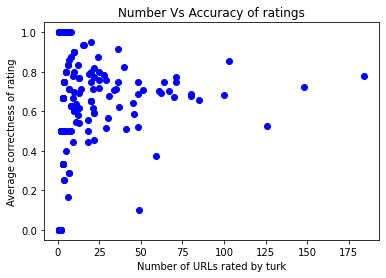

In [20]:
#plotting a graph between average correctness of rating Vs numbr of URLs rated
plot(rater_goodness['count'], rater_goodness['avg_correct'], marker='o', color='blue', linestyle='None')
xlabel('Number of URLs rated by turk')
ylabel('Average correctness of rating')
title('Number Vs Accuracy of ratings')
show()

From the graph, we can see that as the number of URLs rated by turk increases, the average correctness of the rating increases. This validates the assumption about spammers.

# Question 7: Overall predicted odds

In [21]:
# create 2 ranges. One is the bottom 75% (non-reliable) and the other is top 25% (reliable)
#creating a column 'reliable' to store "reliable" and "non-reliable" values for turks above 75 percentile and below 75 percentile respt.
rater_goodness_quantiles = pd.qcut(rater_goodness['count'],[0,.75, 1],
                                labels=['non-reliable', 'reliable'])

# Add reliable column
rater_goodness['reliable'] = rater_goodness_quantiles
rater_goodness.head(2)

,count,avg_correct,odds,reliable
turk,,,,
A112DVP1KG4QZU,1,1.000000,1000.000000,non-reliable
A1253FXHCZ9CWM,29,0.517241,1.069214,reliable


In [22]:
# Check how many are in each category
raters_by_percentile = rater_goodness['reliable'].value_counts()
raters_by_percentile

non-reliable    203
reliable         66
Name: reliable, dtype: int64

In [23]:
# Dataframe of only reliable raters and reset index is done so turk in not index
df_reliable_raters = rater_goodness[rater_goodness['reliable']=="reliable"].reset_index()
df_reliable_raters.head(2)

,turk,count,avg_correct,odds,reliable
0,A1253FXHCZ9CWM,29,0.517241,1.069214,reliable
1,A12RE8G66WTO8B,20,0.750000,2.988048,reliable


In [24]:
# Merge the reliable raters with the unkown urls
merged = df_reliable_raters.merge(labels_unknown,left_on='turk',right_on='turk',
                                  suffixes=['_reliable_raters', '_labels_unknown'])
                            

merged.head(5)

,turk,count,avg_correct,odds,reliable,url,category
0,A1253FXHCZ9CWM,29,0.517241,1.069214,reliable,http://007absolutehardcore.com/early_cumshots/...,P
1,A1253FXHCZ9CWM,29,0.517241,1.069214,reliable,http://10000birds.com,G
2,A1253FXHCZ9CWM,29,0.517241,1.069214,reliable,http://101fetishes.com/femdomtorture/portal.htm,X
3,A1253FXHCZ9CWM,29,0.517241,1.069214,reliable,http://101greatgoals.com,G
4,A1253FXHCZ9CWM,29,0.517241,1.069214,reliable,http://123movers.com,G


In [25]:
len(merged)

37998

In [26]:
# Create a pivot table with the urls as rows and the rating category as colums.
# Fill values with the product of odds

overall_odds = pd.pivot_table(merged,
                                  index='url',
                                  columns='category',
                                  values='odds',
                                  aggfunc=prod,
                                  fill_value=0)

overall_odds

category,G,P,R,X
url,,,,
http://0-101.net,2.297602,0.000000,0.0,0.000000
http://000.cc,1.485456,0.000000,0.0,0.000000
http://0000.jp,14.339248,0.000000,0.0,0.000000
http://000relationships.com,3.841962,1.851852,0.0,0.000000
http://000vitamins.com,4.033641,0.000000,0.0,0.000000
...,...,...,...,...
http://zwinky.com,17.201875,0.000000,0.0,0.000000
http://zylom.com,1.849543,0.000000,0.0,0.000000
http://zynga.com,3.666513,0.000000,0.0,0.000000


In [27]:
#the above results are returned in tabular format
overall_odds_tabular = pd.pivot_table(merged,
                                  index=['url','category'],
                                  #columns='category',
                                  values='odds',
                                  aggfunc=prod,
                                  fill_value=0)

overall_odds_tabular

odds
url                         category           
http://0-101.net            G          2.297602
http://000.cc               G          1.485456
http://0000.jp              G         14.339248
http://000relationships.com G          3.841962
                            P          1.851852
...                                         ...
http://zynga.com            G          3.666513
http://zz868.com            G          1.047852
                            P          1.851852
http://zzx.cc               G          1.417620
                            X          1.620746

[13983 rows x 1 columns]

# Question 8 Predicted Categories

In [28]:
#overall_odds.T.idxmax() is done to get the index (category) for highest product of odds 
result_75_cat_change = overall_odds.T.idxmax().reset_index()
result_75_category = result_75_cat_change.rename(columns = {0: "top category"})
result_75_category

,url,top category
0,http://0-101.net,G
1,http://000.cc,G
2,http://0000.jp,G
3,http://000relationships.com,G
4,http://000vitamins.com,G
...,...,...
10605,http://zwinky.com,G
10606,http://zylom.com,G
10607,http://zynga.com,G
10608,http://zz868.com,P


In [29]:
#overall_odds.T.max() is done to get the highest vaklue of product of odds
result_75_odds_change = overall_odds.T.max().reset_index()
result_75_top_odds = result_75_odds_change.rename(columns = {0: "top odds"})
result_75_top_odds.head()

,url,top odds
0,http://0-101.net,2.297602
1,http://000.cc,1.485456
2,http://0000.jp,14.339248
3,http://000relationships.com,3.841962
4,http://000vitamins.com,4.033641


In [30]:
#combining the previous 2 dfs to generate the result_75 df
result_75 = result_75_category.merge(result_75_top_odds,
                                   left_on='url',
                                   right_on='url')
                            
result_75.set_index('url', inplace = True)
result_75

,top category,top odds
url,,
http://0-101.net,G,2.297602
http://000.cc,G,1.485456
http://0000.jp,G,14.339248
http://000relationships.com,G,3.841962
http://000vitamins.com,G,4.033641
...,...,...
http://zwinky.com,G,17.201875
http://zylom.com,G,1.849543
http://zynga.com,G,3.666513


# Question 9: Predicted categories using more turks

In [31]:
# create 2 ranges. One is the bottom 75% (non-reliable) and the other is top 25% (reliable)
rater_goodness_quantiles_25 = pd.qcut(rater_goodness['count'].rank(method='first'),
                                [0,.25, 1.],
                                labels=['non-reliable','reliable'])

rater_goodness_quantiles_25

turk
A112DVP1KG4QZU    non-reliable
A1253FXHCZ9CWM        reliable
A12CY1Q7XKJJDE    non-reliable
A12RE8G66WTO8B        reliable
A12Y1GTGIQDGRA        reliable
                      ...     
AYWOBMTEGFVVI         reliable
AZ1S5BIG5R6P6         reliable
AZSDW7JJL5VA7         reliable
AZVB3RZW0OR1H         reliable
amurray               reliable
Name: count, Length: 269, dtype: category
Categories (2, object): ['non-reliable' < 'reliable']

In [32]:
# Add reliable column
rater_goodness['reliable'] = rater_goodness_quantiles_25
rater_goodness.head()

,count,avg_correct,odds,reliable
turk,,,,
A112DVP1KG4QZU,1,1.000000,1000.000000,non-reliable
A1253FXHCZ9CWM,29,0.517241,1.069214,reliable
A12CY1Q7XKJJDE,1,1.000000,1000.000000,non-reliable
A12RE8G66WTO8B,20,0.750000,2.988048,reliable
A12Y1GTGIQDGRA,3,0.333333,0.499251,reliable


In [33]:
# Check how many are in each category
raters_by_percentile = rater_goodness['reliable'].value_counts()
raters_by_percentile

reliable        201
non-reliable     68
Name: reliable, dtype: int64

In [34]:
# Dataframe of only reliable raters and reset index is done so turk in not index
df_reliable_raters_25 = rater_goodness[rater_goodness["reliable"]=='reliable'].reset_index()
df_reliable_raters_25.head()

,turk,count,avg_correct,odds,reliable
0,A1253FXHCZ9CWM,29,0.517241,1.069214,reliable
1,A12RE8G66WTO8B,20,0.750000,2.988048,reliable
2,A12Y1GTGIQDGRA,3,0.333333,0.499251,reliable
3,A13OE9GBRJ0S2U,4,0.750000,2.988048,reliable
4,A153PKAL7OAY36,148,0.722973,2.600369,reliable


In [35]:
# Merge the reliable raters with the unkown urls
merged_25 = df_reliable_raters_25.merge(labels_unknown,
                                   left_on='turk',
                                   right_on='turk',
                                   suffixes=['_reliable_raters', '_labels_unknown'])
                            
merged_25.head()

,turk,count,avg_correct,odds,reliable,url,category
0,A1253FXHCZ9CWM,29,0.517241,1.069214,reliable,http://007absolutehardcore.com/early_cumshots/...,P
1,A1253FXHCZ9CWM,29,0.517241,1.069214,reliable,http://10000birds.com,G
2,A1253FXHCZ9CWM,29,0.517241,1.069214,reliable,http://101fetishes.com/femdomtorture/portal.htm,X
3,A1253FXHCZ9CWM,29,0.517241,1.069214,reliable,http://101greatgoals.com,G
4,A1253FXHCZ9CWM,29,0.517241,1.069214,reliable,http://123movers.com,G


In [36]:
# Create a pivot table with the urls as rows and the rating category as colums.
# Fill values with the product of odds

overall_odds_25 = pd.pivot_table(merged_25,
                                  index='url',
                                  columns='category',
                                  values='odds',
                                  aggfunc=prod,
                                  fill_value=0)
overall_odds_25.head()

category,G,P,R,X
url,,,,
http://0-101.net,2.297602e+00,0.000000,0.000000,0.0
http://000.cc,2.218192e+03,0.998004,0.000000,0.0
http://0000.jp,2.847963e+07,0.000000,0.000000,0.0
http://000relationships.com,0.000000e+00,1.851852,0.332889,0.0
http://000vitamins.com,5.343559e+03,0.000000,0.000000,0.0


In [37]:
result_25_cat_change = overall_odds_25.T.idxmax().reset_index()
result_25_category = result_25_cat_change.rename(columns = {0: "top category"})
result_25_category.head()

,url,top category
0,http://0-101.net,G
1,http://000.cc,G
2,http://0000.jp,G
3,http://000relationships.com,P
4,http://000vitamins.com,G


In [38]:
result_25_odds_change = overall_odds_25.T.max().reset_index()
result_25_top_odds = result_25_odds_change.rename(columns = {0: "top odds"})
result_25_top_odds.head()

,url,top odds
0,http://0-101.net,2.297602e+00
1,http://000.cc,2.218192e+03
2,http://0000.jp,2.847963e+07
3,http://000relationships.com,1.851852e+00
4,http://000vitamins.com,5.343559e+03


In [39]:
#combining the previous 2 dfs to generate the result_25 df
result_25 = result_25_category.merge(result_25_top_odds,
                                   left_on='url',
                                   right_on='url',
                                   suffixes=['_category', '_top_odds'])
                            
result_25.set_index('url', inplace = True)
result_25.head()

,top category,top odds
url,,
http://0-101.net,G,2.297602e+00
http://000.cc,G,2.218192e+03
http://0000.jp,G,2.847963e+07
http://000relationships.com,P,1.851852e+00
http://000vitamins.com,G,5.343559e+03


In [40]:
#combination of result_25 and result_75 for comparing the results
results = result_25.merge(result_75,
                                   left_index=True,
                                   right_index=True,
                                   suffixes=['_25', '_75'])
                            
results.reset_index(inplace=True)
results.head()

,url,top category_25,top odds_25,top category_75,top odds_75
0,http://0-101.net,G,2.297602e+00,G,2.297602
1,http://000.cc,G,2.218192e+03,G,1.485456
2,http://0000.jp,G,2.847963e+07,G,14.339248
3,http://000relationships.com,P,1.851852e+00,G,3.841962
4,http://000vitamins.com,G,5.343559e+03,G,4.033641


In [41]:
compare_results = pd.pivot_table(results,
                                  index='top category_75',
                                  columns='top category_25',
                                  values='url',
                                  aggfunc='count',
                                  fill_value=0)
compare_results

top category_25,G,P,R,X
top category_75,,,,
G,8128,686,214,232
P,247,298,51,29
R,24,38,114,32
X,49,5,31,432


From the above comparison, we can see that the highest error has been made when the turks above 75 percentile had categorized G and the turks above 25 percentile had categorized P.